In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Get the Data

We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/dataset/228/sms+spam+collection)!

The file we are using contains a collection of more than 5 thousand SMS phone messages.

Let's go ahead and use rstrip() plus a list comprehension to get a list of all the lines of text messages:

In [2]:
messages=[line.rstrip() for line in open('SMSSpamCollection')]
print(len(messages))

5574


Let's print the first ten messages and number them using enumerate:

In [3]:
for message_no, message in enumerate(messages[:10]):
    print(message_no,message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

Due to the spacing we can tell that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself.

Using these labeled ham and spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

In [4]:
messages=pd.read_csv('SMSSpamCollection',sep='\t',names=['label','message'])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 1. Data Cleaning

In [5]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
# missing values
messages.isnull().sum()

label      0
message    0
dtype: int64

In [7]:
# duplicate values
messages.duplicated().sum()

403

In [8]:
messages.drop_duplicates(keep='first',inplace=True)

In [9]:
messages.duplicated().sum()

0

In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5169 non-null   object
 1   message  5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


# 2. Exploratory Data Analysis

In [11]:
messages['label'].value_counts()

label
ham     4516
spam     653
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

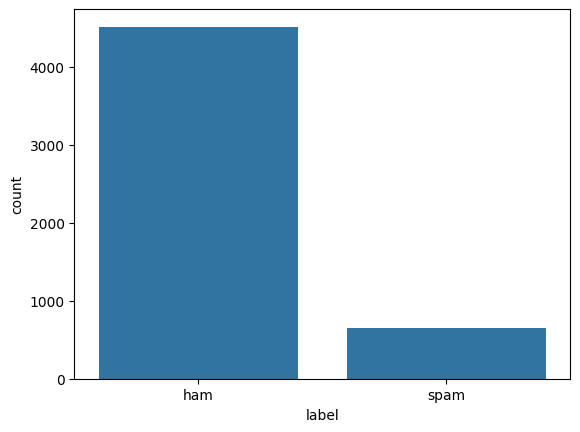

In [12]:
sns.countplot(data=messages,x='label')

In [13]:
# Data is imbalanced

In [14]:
messages.describe()

,label,message
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


In [15]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4516   4516  Go until jurong point, crazy.. Available only ...    1
spam      653    653  Free entry in 2 a wkly comp to win FA Cup fina...    1

In [16]:
messages['length']=messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [17]:
messages.sort_values(by='length',ascending=False).head()

,label,message,length
1085,ham,For me the love should start with attraction.i...,910
1863,ham,The last thing i ever wanted to do was hurt yo...,790
2434,ham,Indians r poor but India is not a poor country...,629
1579,ham,How to Make a girl Happy? It's not at all diff...,611
2158,ham,Sad story of a Man - Last week was my b'day. M...,588


<Axes: xlabel='length', ylabel='Count'>

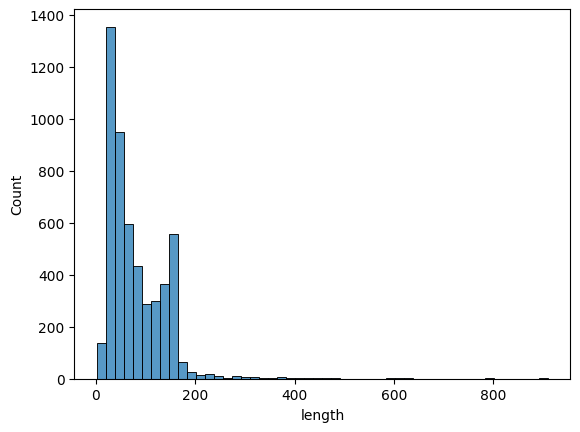

In [18]:
sns.histplot(x='length',data=messages,bins=50)

The x-axis goes all the way to 1000ish, this must mean that there is some really long message!

In [19]:
messages['length'].describe()

count    5169.000000
mean       79.344554
std        58.437457
min         2.000000
25%        36.000000
50%        61.000000
75%       119.000000
max       910.000000
Name: length, dtype: float64

In [20]:
messages[messages['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Looks like a love letter. But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

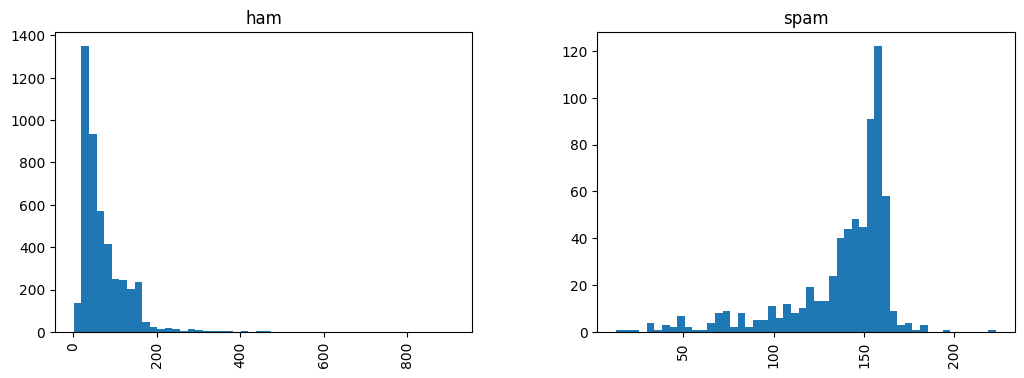

In [21]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

Spam messages tend to have more characters

# 3. Text Pre-processing

In [22]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RISHIT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RISHIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\RISHIT\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
def get_wordnet_pos(tag):
    """
    Map POS tag to WordNet POS tag
    """
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # noun (default)

def text_process(mess):
    # remove punctuations
    # remove stopwords
    # lemmatization
    # return clean message

    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    nostop = [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    pos_tags = pos_tag(nostop)
    clean_mess = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]

    return clean_mess

Now let's tokenize these messages.

In [24]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, go, usf, life, around, though]
Name: message, dtype: object

## Vectorization

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
bow_transformer = CountVectorizer(analyzer=text_process,max_features=4500).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

4500


In [27]:
# Transforming the entire dataset of messages into a bag of words
messages_bow=bow_transformer.transform(messages['message'])

## TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
messages_tfidf= TfidfTransformer().fit_transform(messages_bow)
print(messages_tfidf.shape)

(5169, 4500)


# 4. Training the model

In [29]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [30]:
from sklearn.model_selection import train_test_split
X=messages_tfidf
y=messages['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score
mnb=MultinomialNB()
mnb.fit(X_train,y_train)
predictions = mnb.predict(X_test)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions,y_test))
print(precision_score(y_test,predictions,pos_label='spam'))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98       923
        spam       0.79      1.00      0.88       111

    accuracy                           0.97      1034
   macro avg       0.90      0.98      0.93      1034
weighted avg       0.98      0.97      0.97      1034

[[894  29]
 [  0 111]]
0.971953578336557
1.0


In [32]:
bnb=BernoulliNB()
bnb.fit(X_train,y_train)
predictions = bnb.predict(X_test)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions,y_test))
print(precision_score(y_test,predictions,pos_label='spam'))

              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       909
        spam       0.89      0.99      0.94       125

    accuracy                           0.98      1034
   macro avg       0.94      0.99      0.96      1034
weighted avg       0.99      0.98      0.98      1034

[[893  16]
 [  1 124]]
0.9835589941972921
0.992


We'll give more importance to precision score than accuracy in this case as the data is imbalanced.

## Using a pipeline 

In [33]:
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2, random_state=42)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4135 1034 5169


In [34]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,max_features=4500)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', BernoulliNB()),  # train on TF-IDF vectors with Naive Bayes classifier
])

In [35]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000020B86ADF060>,
                                 max_features=4500)),
                ('tfidf', TfidfTransformer()), ('classifier', BernoulliNB())])

In [36]:
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(label_test,predictions))
print(precision_score(label_test,predictions,pos_label='spam'))

              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       916
        spam       0.84      1.00      0.91       118

    accuracy                           0.98      1034
   macro avg       0.92      0.99      0.95      1034
weighted avg       0.98      0.98      0.98      1034

[[894  22]
 [  0 118]]
0.9787234042553191
1.0


In [37]:
pipeline.predict(['Youve still not claimed the compensation you are due for the accident you had. To start the process please reply YES. To opt out reply STOP. '])

array(['spam'], dtype='<U4')

In [38]:
import pickle
pickle.dump(pipeline,open('pipeline.pkl','wb'))

In [39]:
for message_no, message in enumerate(msg_test[20:30]):
    print(message_no,message)
    print('\n')

0 The house is on the water with a dock, a boat rolled up with a newscaster who dabbles in jazz flute behind the wheel


1 Will purchase d stuff today and mail to you. Do you have a po box number?


2 … we r stayin here an extra week, back next wed. How did we do in the rugby this weekend? Hi to and and , c u soon "


3 I'm taking derek &amp; taylor to walmart, if I'm not back by the time you're done just leave the mouse on my desk and I'll text you when priscilla's ready


4 This message is free. Welcome to the new & improved Sex & Dogging club! To unsubscribe from this service reply STOP. msgs@150p 18 only


5 Yeah confirmed for you staying at  that weekend


6 You have won a Nokia 7250i. This is what you get when you win our FREE auction. To take part send Nokia to 86021 now. HG/Suite342/2Lands Row/W1JHL 16+


7 I am in your office na.


8 7 at esplanade.. Do ü mind giving me a lift cos i got no car today..


9 Yeah. I got a list with only u and Joanna if I'm feeling really anti soc

# Handling Imbalance In the Dataset

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Undersampling Majority Class 

In [41]:
df = pd.read_csv('SMSSpamCollection', sep='\t', names = ['label', 'text'])
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [43]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [44]:
df.duplicated().sum()

403

In [45]:
df [ df.duplicated() == True ] 

,label,text
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [46]:
df.drop_duplicates(keep='first',inplace=True)
df.duplicated().sum()

0

In [47]:
df['label'].value_counts()

label
ham     4516
spam     653
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

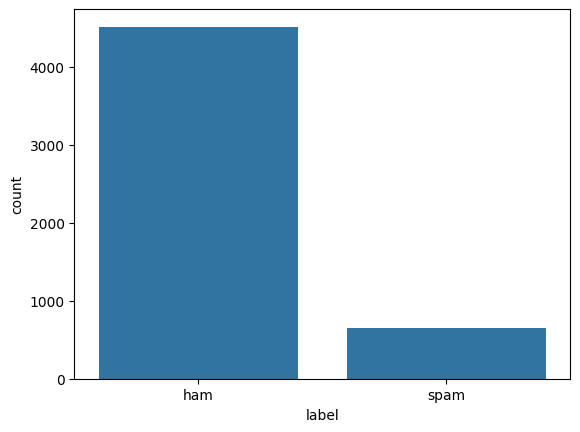

In [48]:
sns.countplot(data = df, x = 'label')

In [49]:
df_ham = df[df['label'] == 'ham']
df_spam = df[df['label'] == 'spam']
df_ham_under = df_ham.sample(len(df_spam))

df_under = pd.concat([df_spam, df_ham_under], axis= 0)

In [50]:
df_under = df_under.sample(frac=1)
df_under.reset_index(drop = True, inplace = True)
df_under.head()

,label,text
0,spam,TBS/PERSOLVO. been chasing us since Sept for£3...
1,ham,"I want to show you the world, princess :) how ..."
2,spam,SMS SERVICES For your inclusive text credits p...
3,ham,Be happy there. I will come after noon
4,ham,And he's apparently bffs with carly quick now


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


X = df_under['text']
y = df_under['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

model = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', MultinomialNB())])

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         ham       0.95      0.98      0.96       133
        spam       0.98      0.95      0.96       129

    accuracy                           0.96       262
   macro avg       0.96      0.96      0.96       262
weighted avg       0.96      0.96      0.96       262



In [52]:
def clf(df):
    
    X = df['text']
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    model.fit(X_train, y_train)

    y_preds = model.predict(X_test)

    print(classification_report(y_test, y_preds))

In [53]:
clf(df_under)

              precision    recall  f1-score   support

         ham       0.96      0.97      0.96       127
        spam       0.97      0.96      0.97       135

    accuracy                           0.97       262
   macro avg       0.97      0.97      0.97       262
weighted avg       0.97      0.97      0.97       262



## 2. Oversampling majority class

In [54]:
df_spam_over = df_spam.sample(n = len(df_ham), replace=True)

df_over = pd.concat([df_spam_over, df_ham], axis = 0)
df_over = df_over.sample(frac=1)
df_over.reset_index(drop = True, inplace = True)
df_over.head()

,label,text
0,spam,25p 4 alfie Moon's Children in need song on ur...
1,spam,Join the UK's horniest Dogging service and u c...
2,spam,We tried to contact you re your reply to our o...
3,ham,Nan sonathaya soladha. Why boss?
4,ham,Dude im no longer a pisces. Im an aquarius now.


In [55]:
clf(df_over)

              precision    recall  f1-score   support

         ham       0.97      0.98      0.98       901
        spam       0.98      0.97      0.98       906

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807



## 3. SMOTE (Synthetic Minority Over Sampling Technique)

In [56]:
pip install imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/235.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/235.6 kB ? eta -:--:--
   ------ -------------------------------- 41.0/235.6 kB 393.8 kB/s eta 0:00:01
   ------------------- ------------------ 122.9/235.6 kB 798.9 kB/s eta 0:00:01
   ---------------------------------------- 235.6/235.6 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [57]:
from imblearn.over_sampling import SMOTE

In [58]:
count_vectorizer = CountVectorizer()
X_int_tokens = count_vectorizer.fit_transform(df['text'])

X = X_int_tokens
y = df['label']

sm = SMOTE(sampling_strategy='minority')
X_sm, y_sm = sm.fit_resample(X, y)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = .2)

model = Pipeline([
        ('clf', MultinomialNB())
])

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         ham       0.97      0.98      0.97       908
        spam       0.98      0.97      0.97       899

    accuracy                           0.97      1807
   macro avg       0.97      0.97      0.97      1807
weighted avg       0.97      0.97      0.97      1807



In [60]:
y_train.value_counts()

label
spam    3617
ham     3608
Name: count, dtype: int64

## 4. Ensemble Method (Under Sampling Majority Class)

In [61]:
df.shape

(5169, 2)

In [62]:
df_ham.shape, df_spam.shape

((4516, 2), (653, 2))

In [63]:
len(df_ham)/len(df_spam)

6.915773353751915

In [64]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

y_train.value_counts()

label
ham     3610
spam     525
Name: count, dtype: int64

In [65]:
df_train = pd.DataFrame({'text':X_train,
                        'label':y_train})

In [66]:
3619/516

7.013565891472868

In [67]:
# We need 7 under sampled samples of df_train to make around 7 models
df_train_ham = df_train[df_train['label'] == 'ham']
df_train_spam = df_train[df_train['label'] == 'spam']

df_train_ham_samples = []

for i in np.arange(516,3620,516):
    df_train_ham_sample = df_train_ham[i-516:i+1]
    df_train_ham_samples.append(df_train_ham_sample)

In [68]:
def model(df_ham, df_spam):
    
    df_train = pd.concat([df_ham, df_spam], axis = 0)
    df_train = df_train.sample(frac=1)
    X_train = df_train['text']
    y_train = df_train['label']
    
    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    model.fit(X_train, y_train)

    y_preds = model.predict(X_test)
    print(classification_report(y_test, y_preds))
    
    return y_preds



In [69]:
y_preds_all_models = []

for i in range(0,7):
    y_preds = model(df_train_ham_samples[i], df_train_spam)
    y_preds_all_models.append(y_preds)

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98       906
        spam       0.76      0.97      0.85       128

    accuracy                           0.96      1034
   macro avg       0.88      0.96      0.91      1034
weighted avg       0.97      0.96      0.96      1034

              precision    recall  f1-score   support

         ham       1.00      0.95      0.97       906
        spam       0.74      0.98      0.84       128

    accuracy                           0.95      1034
   macro avg       0.87      0.96      0.91      1034
weighted avg       0.96      0.95      0.96      1034

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98       906
        spam       0.76      0.97      0.85       128

    accuracy                           0.96      1034
   macro avg       0.88      0.96      0.91      1034
weighted avg       0.97      0.96      0.96      1034

              preci

In [70]:
y_preds_all_models = np.array(y_preds_all_models)

In [71]:
y_preds_all_models.shape

(7, 1034)

In [72]:
y_preds_all_models.transpose()

array([['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'],
       ['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'],
       ['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'],
       ...,
       ['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'],
       ['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'],
       ['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham']], dtype='<U4')

In [73]:
y_preds_final = []

for i in y_preds_all_models.transpose():
    count = 0
    for j in i:
        if j == 'ham':
            count+=1
    
    if count>3:
        y_preds_final.append('ham')
    else:
        y_preds_final.append('spam')

In [74]:
y_preds_final = np.array(y_preds_final)

In [75]:
y_test.shape

(1034,)

In [76]:
y_preds_final.shape

(1034,)

In [77]:
print(classification_report(y_test, y_preds_final))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98       906
        spam       0.76      0.97      0.85       128

    accuracy                           0.96      1034
   macro avg       0.88      0.96      0.91      1034
weighted avg       0.97      0.96      0.96      1034



In [78]:
np.arange(516,3620,516)

array([ 516, 1032, 1548, 2064, 2580, 3096, 3612])

## 5. Focal Loss (Using ANN)

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

df = pd.read_csv('SMSSpamCollection', sep='\t', names = ['label', 'text'])
df.drop_duplicates()

X = df['text']
y = df['label']
y = pd.get_dummies(y, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [80]:
y.value_counts()

spam 
False    4825
True      747
Name: count, dtype: int64

In [81]:
num_tokens = [len(i.split()) for i in df['text']]
np.mean(num_tokens), np.max(num_tokens), np.percentile(num_tokens, 95), np.sum(num_tokens)

(15.597451543431443, 171, 33.0, 86909)

(array([3.573e+03, 1.796e+03, 1.400e+02, 3.600e+01, 1.500e+01, 6.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([  1.,  18.,  35.,  52.,  69.,  86., 103., 120., 137., 154., 171.]),
 <BarContainer object of 10 artists>)

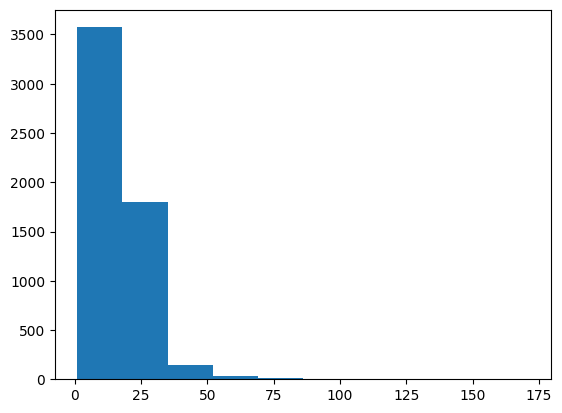

In [82]:
plt.hist(num_tokens)

### Model 1 - Using Binary Crossentropy

In [83]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = np.sum(num_tokens),
                                   output_sequence_length = int(np.percentile(num_tokens, 95)))

text_vectorizer.adapt(X_train)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=np.sum(num_tokens),
                              input_length=int(np.percentile(num_tokens, 95)),
                              output_dim=128),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Using just Binary Crossentropy
model_1.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [84]:
text_vectorizer(['My name is Cristiano Ronaldo'])

<tf.Tensor: shape=(1, 33), dtype=int64, numpy=
array([[ 12, 249,  10,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=int64)>

In [85]:
len(text_vectorizer.get_vocabulary())

8509

In [86]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 33)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 33, 128)           11124352  
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 11124481 (42.44 MB)
Trainable params: 11124481 (42.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [89]:
history_1 = model_1.fit(X_train, y_train,
          epochs = 10,
          batch_size = 32,
          validation_data = (X_test, y_test))

Epoch 1/10
140/140 [==============================] - 22s 151ms/step - loss: 0.4829 - accuracy: 0.8432 - val_loss: 0.3520 - val_accuracy: 0.8664
Epoch 2/10
140/140 [==============================] - 21s 150ms/step - loss: 0.2935 - accuracy: 0.8678 - val_loss: 0.2247 - val_accuracy: 0.9040
Epoch 3/10
140/140 [==============================] - 21s 149ms/step - loss: 0.1654 - accuracy: 0.9470 - val_loss: 0.1266 - val_accuracy: 0.9677
Epoch 4/10
140/140 [==============================] - 21s 148ms/step - loss: 0.0903 - accuracy: 0.9780 - val_loss: 0.0861 - val_accuracy: 0.9794
Epoch 5/10
140/140 [==============================] - 21s 149ms/step - loss: 0.0552 - accuracy: 0.9883 - val_loss: 0.0675 - val_accuracy: 0.9812
Epoch 6/10
140/140 [==============================] - 21s 152ms/step - loss: 0.0365 - accuracy: 0.9939 - val_loss: 0.0572 - val_accuracy: 0.9865
Epoch 7/10
140/140 [==============================] - 23s 161ms/step - loss: 0.0253 - accuracy: 0.9957 - val_loss: 0.0510 - val_ac

In [90]:
from sklearn.metrics import classification_report

def clf_rep(ANN_model):
    y_pred_probs = ANN_model.predict(X_test)
    y_preds = tf.round(y_pred_probs)
    print(classification_report(y_test, y_preds))

In [91]:
clf_rep(model_1)

35/35 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       966
        True       1.00      0.92      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [92]:
y_pred_probs = model_1.predict(X_test)

35/35 [==============================] - 0s 1ms/step


In [93]:
model_1.evaluate(X_test, y_test)

35/35 [==============================] - 0s 2ms/step - loss: 0.0424 - accuracy: 0.9892


[0.04243918135762215, 0.9892376661300659]

### Model 2 - Using Binary Focal Crossentropy

In [94]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=np.sum(num_tokens),
                              input_length=int(np.percentile(num_tokens, 95)),
                              output_dim=128),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = 'binary_focal_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [95]:
history_2 = model_2.fit(X_train, y_train,
           epochs = 10,
           batch_size = 32,
           validation_data = (X_test, y_test))

Epoch 1/10
140/140 [==============================] - 22s 154ms/step - loss: 0.1019 - accuracy: 0.8512 - val_loss: 0.0698 - val_accuracy: 0.8664
Epoch 2/10
140/140 [==============================] - 20s 144ms/step - loss: 0.0470 - accuracy: 0.9325 - val_loss: 0.0307 - val_accuracy: 0.9713
Epoch 3/10
140/140 [==============================] - 21s 149ms/step - loss: 0.0193 - accuracy: 0.9841 - val_loss: 0.0180 - val_accuracy: 0.9839
Epoch 4/10
140/140 [==============================] - 21s 148ms/step - loss: 0.0096 - accuracy: 0.9937 - val_loss: 0.0137 - val_accuracy: 0.9874
Epoch 5/10
140/140 [==============================] - 21s 153ms/step - loss: 0.0055 - accuracy: 0.9969 - val_loss: 0.0119 - val_accuracy: 0.9883
Epoch 6/10
140/140 [==============================] - 21s 153ms/step - loss: 0.0034 - accuracy: 0.9982 - val_loss: 0.0108 - val_accuracy: 0.9901
Epoch 7/10
140/140 [==============================] - 21s 148ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0102 - val_ac

In [96]:
clf_rep(model_2)

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       966
        True       1.00      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115

